<a href="https://colab.research.google.com/github/ShreyPandit/Lipschitz/blob/master/Iris_Lipschitz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

!pip install tensorflow==1.14.0

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:
iris=pd.read_csv("Iris.csv")

In [3]:
from sklearn.utils import shuffle
iris=shuffle(iris)
iris.pop('Id')
iris

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
49,5.0,3.3,1.4,0.2,Iris-setosa
124,6.7,3.3,5.7,2.1,Iris-virginica
35,5.0,3.2,1.2,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
...,...,...,...,...,...
128,6.4,2.8,5.6,2.1,Iris-virginica
101,5.8,2.7,5.1,1.9,Iris-virginica
10,5.4,3.7,1.5,0.2,Iris-setosa
111,6.4,2.7,5.3,1.9,Iris-virginica


In [0]:
one_hot = pd.get_dummies(iris['Species'])

In [5]:
iris.pop('Species')

49        Iris-setosa
124    Iris-virginica
35        Iris-setosa
1         Iris-setosa
8         Iris-setosa
            ...      
128    Iris-virginica
101    Iris-virginica
10        Iris-setosa
111    Iris-virginica
103    Iris-virginica
Name: Species, Length: 150, dtype: object

In [0]:
train_x=iris.iloc[0:125,:]

In [0]:
test_x=iris.iloc[125:,:]

In [0]:
train_y=one_hot.iloc[0:125,:]

In [0]:
test_y=one_hot.iloc[125:,:]

In [10]:
print(len(train_x),len(train_y),len(test_x),len(test_y))
print(len(one_hot))

125 125 25 25
150


In [0]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, input_dim = 4 , activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(8, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(10, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [147]:
len(train_y)

125

In [148]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 10)                50        
_________________________________________________________________
dropout_48 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 8)                 88        
_________________________________________________________________
dropout_49 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_62 (Dense)             (None, 16)                144       
_________________________________________________________________
dropout_50 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 10)              

In [0]:
from keras import backend as K
func = K.function([model.layers[0].input], [model.layers[-2].output])

In [0]:
K1 = 0.
K2 = 0.
beta1 = 0.9
beta2 = 0.999
batch_size=125
num_classes = 3
epochs = 50
lrs=[]

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    global K1, K2

    Kz = 0.  # max penultimate activation
    S = 0.
    
    sess = K.get_session()
    max_wt = 0.
    for weight in model.weights:
        norm = np.linalg.norm(weight.eval(sess))
        if norm > max_wt:
            max_wt = norm
    
    for i in range((len(train_x) - 1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = train_x[start_i:end_i]
        #print(xb)
        tmp = np.array(func([xb]))
        activ = np.linalg.norm(tmp)
        sq = np.linalg.norm(np.square(tmp))

        if sq > S:
          S = sq
        
        if activ > Kz:
          print("value of active is ", activ," and the value of Kz is",Kz)
          Kz = activ

    K_ = ((num_classes - 1) * Kz) / (num_classes * batch_size)
    S_ = (num_classes - 1) ** 2 / (num_classes * batch_size) ** 2 * S
    
    K1 = beta1 * K1 + (1 - beta1) * K_
    K2 = beta2 * K2 + (1 - beta2) * S_

    lr = (np.sqrt(K2) + K.epsilon()) / K1
    print('S =', S, ', K1 =', K1,', K2 =', K2, ', K_ =', K_, ', lr =', lr)
    lrs.append(lr)
    print('Epoch', epoch, 'LR =', lr)
    return lr


lr_scheduler = LearningRateScheduler(lr_schedule)


In [0]:
model.compile(loss = 'categorical_crossentropy' , optimizer=keras.optimizers.Adam(lr=1e-5) , metrics = ['accuracy'] )

In [153]:
history=model.fit(train_x, train_y, epochs = 50, batch_size = 125,validation_data=(test_x,test_y),callbacks=[lr_scheduler])

Train on 125 samples, validate on 25 samples
value of active is  9.893211  and the value of Kz is 0.0
S = 5.193198 , K1 = 0.005276379394531248 , K2 = 1.4771763780381958e-07 , K_ = 0.0527637939453125 , lr = 0.0728606672290673
Epoch 0 LR = 0.0728606672290673
Epoch 1/50
125/125 [==============================] - 1s 6ms/sample - loss: 1.3964 - acc: 0.2880 - val_loss: 1.0907 - val_acc: 0.2800
value of active is  1.6332808  and the value of Kz is 0.0
S = 0.26265204 , K1 = 0.005619824523925779 , K2 = 1.5504091151258695e-07 , K_ = 0.008710830688476563 , lr = 0.07008267718479612
Epoch 1 LR = 0.07008267718479612
Epoch 2/50
125/125 [==============================] - 0s 46us/sample - loss: 1.1579 - acc: 0.2720 - val_loss: 1.0973 - val_acc: 0.6800
value of active is  2.491582  and the value of Kz is 0.0
S = 0.4860369 , K1 = 0.006386685760498044 , K2 = 1.6871092010736776e-07 , K_ = 0.013288436889648437 , lr = 0.06432825478673099
Epoch 2 LR = 0.06432825478673099
Epoch 3/50
125/125 [==================

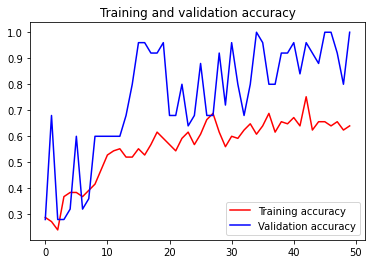

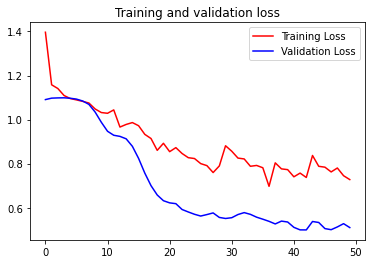

In [154]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()